<a href="https://colab.research.google.com/github/Meenakshi72/ML/blob/main/DATAANALYSIS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! wget https://repo.anaconda.com/miniconda/Miniconda3-py37_4.8.2-Linux-x86_64.sh
! chmod +x Miniconda3-py37_4.8.2-Linux-x86_64.sh
! bash ./Miniconda3-py37_4.8.2-Linux-x86_64.sh -b -f -p /usr/local
! conda install -c rdkit rdkit -y
import sys
sys.path.append('/usr/local/lib/python3.7/site-packages/')

In [ ]:
import pandas as pd

In [ ]:
df = pd.read_csv('bioactivity_data_preprocessed.csv')
df

In [ ]:
import numpy as np
from rdkit import Chem
from rdkit.Chem import Descriptors, Lipinski

In [ ]:
def lipinski(smiles, verbose=False):

    moldata= []
    for elem in smiles:
        mol=Chem.MolFromSmiles(elem) 
        moldata.append(mol)
       
    baseData= np.arange(1,1)
    i=0  
    for mol in moldata:        
       
        desc_MolWt = Descriptors.MolWt(mol)
        desc_MolLogP = Descriptors.MolLogP(mol)
        desc_NumHDonors = Lipinski.NumHDonors(mol)
        desc_NumHAcceptors = Lipinski.NumHAcceptors(mol)
           
        row = np.array([desc_MolWt,
                        desc_MolLogP,
                        desc_NumHDonors,
                        desc_NumHAcceptors])   
    
        if(i==0):
            baseData=row
        else:
            baseData=np.vstack([baseData, row])
        i=i+1      
    
    columnNames=["MW","LogP","NumHDonors","NumHAcceptors"]   
    descriptors = pd.DataFrame(data=baseData,columns=columnNames)
    
    return descriptors

In [ ]:
df_lipinski = lipinski(df.canonical_smiles)

In [ ]:
df_lipinski

,MW,LogP,NumHDonors,NumHAcceptors
0,281.271,1.89262,0.0,5.0
1,415.589,3.81320,0.0,2.0
2,421.190,2.66050,0.0,4.0
3,293.347,3.63080,0.0,3.0
4,338.344,3.53900,0.0,5.0
...,...,...,...,...
114,294.350,4.24792,0.0,3.0
115,310.349,3.22032,1.0,4.0
116,338.359,3.40102,0.0,5.0
117,296.366,3.44330,0.0,3.0


In [ ]:
df

In [ ]:
df_combined = pd.concat([df,df_lipinski], axis=1)

In [ ]:
df_combined

In [ ]:
import numpy as np

def pIC50(input):
    pIC50 = []

    for i in input['standard_value_norm']:
        molar = i*(10**-9) # Converts nM to M
        pIC50.append(-np.log10(molar))

    input['pIC50'] = pIC50
    x = input.drop('standard_value_norm', 1)
        
    return x

In [ ]:
-np.log10( (10**-9)* 100000000 )
-np.log10( (10**-9)* 10000000000 )

-1.0

In [ ]:
def norm_value(input):
    norm = []

    for i in input['standard_value']:
        if i > 100000000:
          i = 100000000
        norm.append(i)

    input['standard_value_norm'] = norm
    x = input.drop('standard_value', 1)
        
    return x

In [ ]:
df_norm = norm_value(df_combined)
df_norm

In [ ]:
df_norm.standard_value_norm.describe()

In [ ]:
df_final = pIC50(df_norm)
df_final

In [ ]:
df_final.pIC50.describe()

In [ ]:
df_2class = df_final[df_final.bioactivity_class != 'intermediate']
df_2class

In [ ]:
import seaborn as sns
sns.set(style='ticks')
import matplotlib.pyplot as plt

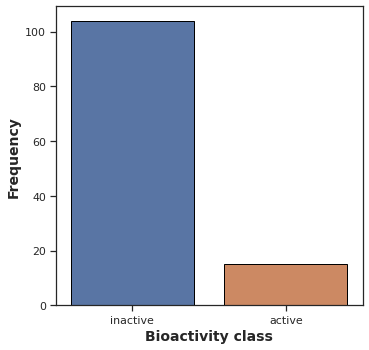

In [ ]:
plt.figure(figsize=(5.5, 5.5))

sns.countplot(x='bioactivity_class', data=df_2class, edgecolor='black')

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('Frequency', fontsize=14, fontweight='bold')

plt.savefig('plot_bioactivity_class.pdf')

In [ ]:
plt.figure(figsize=(5.5, 5.5))

sns.scatterplot(x='MW', y='LogP', data=df_2class, hue='bioactivity_class', size='pIC50', edgecolor='black', alpha=0.7)

plt.xlabel('MW', fontsize=14, fontweight='bold')
plt.ylabel('LogP', fontsize=14, fontweight='bold')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
plt.savefig('plot_MW_vs_LogP.pdf')

In [ ]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'bioactivity_class', y = 'pIC50', data = df_2class)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('pIC50 value', fontsize=14, fontweight='bold')

plt.savefig('plot_ic50.pdf')

In [ ]:
def mannwhitney(descriptor, verbose=False):
  # https://machinelearningmastery.com/nonparametric-statistical-significance-tests-in-python/
  from numpy.random import seed
  from numpy.random import randn
  from scipy.stats import mannwhitneyu

# seed the random number generator
  seed(1)

# actives and inactives
  selection = [descriptor, 'bioactivity_class']
  df = df_2class[selection]
  active = df[df.bioactivity_class == 'active']
  active = active[descriptor]

  selection = [descriptor, 'bioactivity_class']
  df = df_2class[selection]
  inactive = df[df.bioactivity_class == 'inactive']
  inactive = inactive[descriptor]

# compare samples
  stat, p = mannwhitneyu(active, inactive)
  #print('Statistics=%.3f, p=%.3f' % (stat, p))

# interpret
  alpha = 0.05
  if p > alpha:
    interpretation = 'Same distribution (fail to reject H0)'
  else:
    interpretation = 'Different distribution (reject H0)'
  
  results = pd.DataFrame({'Descriptor':descriptor,
                          'Statistics':stat,
                          'p':p,
                          'alpha':alpha,
                          'Interpretation':interpretation}, index=[0])
  filename = 'mannwhitneyu_' + descriptor + '.csv'
  results.to_csv(filename)

  return results

In [ ]:
mannwhitney('pIC50')

,Descriptor,Statistics,p,alpha,Interpretation
0,pIC50,972.0,0.122713,0.05,Same distribution (fail to reject H0)


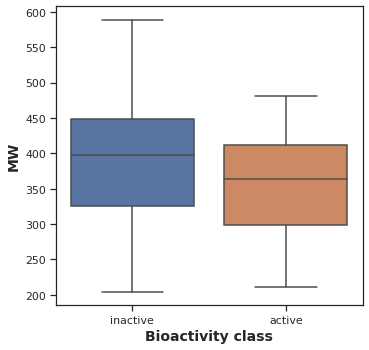

In [ ]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'bioactivity_class', y = 'MW', data = df_2class)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('MW', fontsize=14, fontweight='bold')

plt.savefig('plot_MW.pdf')

In [ ]:
mannwhitney('MW')

,Descriptor,Statistics,p,alpha,Interpretation
0,MW,628.0,0.225107,0.05,Same distribution (fail to reject H0)


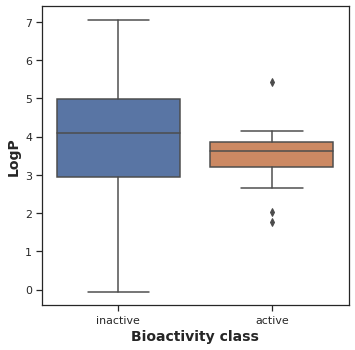

In [ ]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'bioactivity_class', y = 'LogP', data = df_2class)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('LogP', fontsize=14, fontweight='bold')

plt.savefig('plot_LogP.pdf')

In [ ]:
mannwhitney('LogP')

,Descriptor,Statistics,p,alpha,Interpretation
0,LogP,608.0,0.169684,0.05,Same distribution (fail to reject H0)


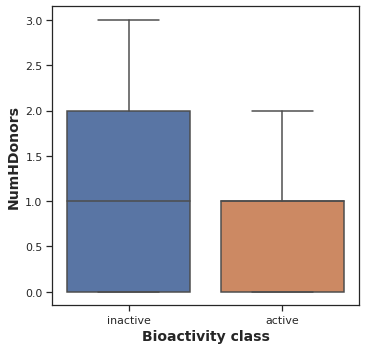

In [ ]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'bioactivity_class', y = 'NumHDonors', data = df_2class)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('NumHDonors', fontsize=14, fontweight='bold')

plt.savefig('plot_NumHDonors.pdf')

In [ ]:
mannwhitney('NumHDonors')

,Descriptor,Statistics,p,alpha,Interpretation
0,NumHDonors,599.5,0.128211,0.05,Same distribution (fail to reject H0)


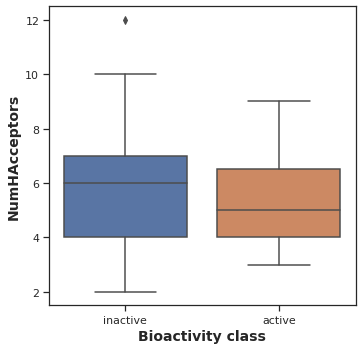

In [ ]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'bioactivity_class', y = 'NumHAcceptors', data = df_2class)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('NumHAcceptors', fontsize=14, fontweight='bold')

plt.savefig('plot_NumHAcceptors.pdf')

In [ ]:
mannwhitney('NumHAcceptors')

,Descriptor,Statistics,p,alpha,Interpretation
0,NumHAcceptors,726.0,0.664241,0.05,Same distribution (fail to reject H0)


In [ ]:
! zip -r results.zip . -i *.csv *.pdf

  adding: plot_LogP.pdf (deflated 37%)
  adding: bioactivity_data_preprocessed.csv (deflated 79%)
  adding: plot_MW.pdf (deflated 38%)
  adding: mannwhitneyu_pIC50.csv (deflated 10%)
  adding: mannwhitneyu_NumHDonors.csv (deflated 10%)
  adding: plot_bioactivity_class.pdf (deflated 38%)
  adding: plot_ic50.pdf (deflated 37%)
  adding: plot_MW_vs_LogP.pdf (deflated 15%)
  adding: mannwhitneyu_MW.csv (deflated 8%)
  adding: mannwhitneyu_NumHAcceptors.csv (deflated 10%)
  adding: plot_NumHDonors.pdf (deflated 38%)
  adding: mannwhitneyu_LogP.csv (deflated 8%)
  adding: plot_NumHAcceptors.pdf (deflated 37%)
